In [1]:
# Install Required Libraries
!pip install transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cu

In [2]:
# Import Libraries
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from datasets import load_dataset

In [3]:
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Load BERT Tokenizer and Model
model_id = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_id)
model = TFBertForSequenceClassification.from_pretrained(model_id, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#Tokenize with smaller max length
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)  # 64 tokens max

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
BATCH_SIZE = 8

In [13]:
train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [14]:
test_dataset = tokenized_datasets['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [19]:
history = model.fit(
    train_dataset.take(100),    # 100 batches for training
    validation_data=test_dataset.take(20),   # 20 batches for validation
    epochs=3    # 3 epochs
)

Epoch 1/3
100/100 [==============================] - 693s 7s/step - loss: 0.5201 - accuracy: 0.7412 - val_loss: 0.5768 - val_accuracy: 0.7312
Epoch 2/3
100/100 [==============================] - 689s 7s/step - loss: 0.4515 - accuracy: 0.7788 - val_loss: 0.6657 - val_accuracy: 0.6500
Epoch 3/3
100/100 [==============================] - 681s 7s/step - loss: 0.4302 - accuracy: 0.8037 - val_loss: 0.3816 - val_accuracy: 0.8438


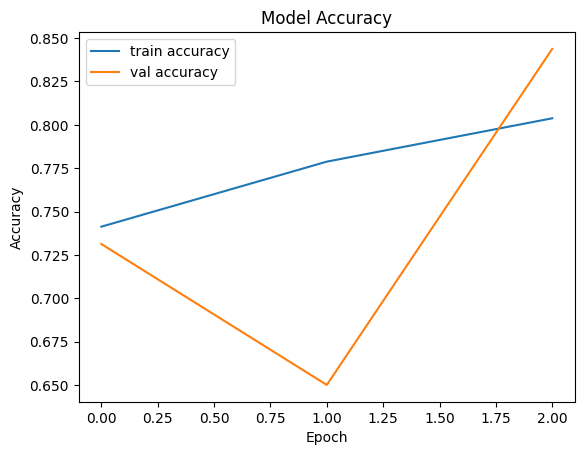

In [20]:
# Plot Training History
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Quick Test
sample_texts = ["This movie was absolutely wonderful!", "I hated the film. Worst ever."]
inputs = tokenizer(sample_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
outputs = model(inputs)


In [22]:
predictions = tf.nn.softmax(outputs.logits, axis=-1)
predicted_labels = tf.argmax(predictions, axis=1)
print("Predicted Labels:", predicted_labels.numpy())

Predicted Labels: [1 0]
